# __The use of DEM data compared to synthetic data in LEMs: Study case on Teton Fault - Wyoming__

## Contents of this Notebook: 
- 1 Study Objectives
- 2 An Introduction to the Teton mountain range and fault 
- 3 Methods Description  
- 4 Longitudinal Profiles
- 5 Ksn and Chi
- 6 - Running the experiments with DEMs
- 7 - Running the experiments with synthetic data
- 8 - Comparing results
- 9 - Conclusion

Lets begin by importing the packages we will be using in this Notebook 

In [1]:
#import statements
import numpy as np
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node
from landlab.components import FlowAccumulator, StreamPowerEroder, SteepnessFinder, ChiFinder, ChannelProfiler, DepressionFinderAndRouter
from landlab.io import write_esri_ascii
import matplotlib as plt
from bmi_topography import Topography
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

__1. Study Objectives__ 
- To characterise the topography of catchments draining the Teton mountain range
- To simulate landscape evolution using a numerical model based on observations of the Teton
- To compare topographic observations of the natural Teton with synthetic numerical modelling  

__2. An Introduction to the Teton Mountain Range and Fault__

The Grand Teton Fault in Wyoming is a normal fault with a dip angle of approximately 50 degrees.

Using OpenToporgaphy we can visualise the topography of the Teton mountain range.

To access OpenTopography data and account and user API key are required. 

In [2]:
#Place your OpenTopogrpahy API key below in order to access data from OpenTopography 
API_key = "70aba841de85bd9dd906f616027b8d2c"

By specifying the coordinate extents of the site we are interested in visualing (north, east, south, west) we can import a DEM of our study region. 

In [3]:
#This section is used to import open topography data for the study site the grand teton mountain range 
the_grand_teton = Topography(north=44, 
                             south=43, 
                             east=-110, 
                             west=-112,
                             output_format="GTiff",
                             dem_type="SRTMGL3", 
                             api_key=API_key)

the_grand_teton_DEM = the_grand_teton.load()
z = np.flipud(the_grand_teton_DEM.values.squeeze())

grid = RasterModelGrid(z.shape, xy_spacing=(90, 150)) #These values reflect a conversion for latitude 
grid.at_node["topographic__elevation"] = z

#Show the grid we have 
grid.imshow("topographic__elevation", cmap="terrain", vmin=0)

KeyboardInterrupt: 

Now we will zoom into our study site by specifying more local coordinates of the catchments in the Teton we are interested.  

In [ ]:
# This section is used to import open topography data for the study site the grand teton mountain range
the_grand_teton = Topography(north=43.891224,
                             south=43.657248, 
                             east=-110.731375, 
                             west=-111.051308, 
                             output_format="GTiff",
                             dem_type="SRTMGL1",
                             api_key= API_key)

the_grand_teton_DEM = the_grand_teton.load()
z = np.flipud(the_grand_teton_DEM.values.squeeze())

grid = RasterModelGrid(z.shape, xy_spacing=(30, 50)) #come back to this bit
grid.at_node["topographic__elevation"] = z/1000*1000

# Show the grid we have
grid.imshow("topographic__elevation", cmap="terrain", vmin=0)

### 3. Methods
*This section will briefly introduce each method used to analyse and compare the observed and synthetic landscapes* <-- Needs to be written
* Longitudinal profiles
* Channel Steepness (see review paper [Smith 2022](https://www.sciencedirect.com/science/article/pii/S001282522200054X))
* Chi [Royden 2000](https://scholar.google.com/citations?view_op=view_citation&hl=th&user=gfqeKSgAAAAJ&cstart=100&pagesize=100&sortby=pubdate&citation_for_view=gfqeKSgAAAAJ:nZcligLrVowC), [Harkins 2007](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006JF000570), [Royden & Perron 2013](https://onlinelibrary.wiley.com/doi/full/10.1002/esp.3302)

__4 Topographic Analysis of the Teton__

Now we know what the Grand Teton looks like, we can begin our topographical analysis of the site. 

To do this we will focus on three tools for fluvial topogrpahic analysis: 
- A - The extraction of channel longitudinal profiles. 
- B - An anlysis of channel steepness; a metric that considers how steep any given channel is. 
- C - An analysis of channel chi; a metric that integrates channel flow distance and normalises for drainage area.

But first we must clip the DEM to a base level we define as 2100 m 

In [ ]:
base_level = 2100

# Mask the grid nodes with the elevation less than 2100 m to set the base level elevation same for the all drainages for chi calculation
grid.status_at_node[grid.at_node["topographic__elevation"]<2100.0]=grid.BC_NODE_IS_CLOSED
grid.imshow("topographic__elevation", cmap="terrain", vmin=0,color_for_closed=None)

__A: Channel Longitudinal Profiles__

First we apply a flow accumulation component to our grid to consider the flow path of channels in our study site. We do this using the landlab FlowAccumulator component. 

We then use the landlab component ChannelProfiler to extract the channel longitudinal profiles. 

In [ ]:
#Apply the FlowAccumulator 
#fa = FlowAccumulator(grid,flow_director='D8')
grid = DepressionFinderAndRouter(grid)
fa.run_one_step()

sf = SteepnessFinder(grid,reference_concavity=0.45,min_drainage_area=100000.0)
cf = ChiFinder(grid,reference_concavity=0.45,min_drainage_area=100000.0)


__B: Normalised Channel Steepness__

__C: Chi__

## Numerical Modelling

### How can landscape evolution models be used to mimic a normal-faulted landscape?
We seek to generate a synthetic landscape which is an approximation of the observed DEM of the Teton fault region.

A simple landscape evolution model for understanding long-term tectonic evolution should consider fluvial erosion and diffusion. Mathematically, this can be represented as:
$\frac{dz}{dt} = U - E + \eta$, where $E = KA^mS^n + D\nabla^2z$

What are the key variables that we need to consider when setting up the model?

1. Model dimensions and boundary conditions
   * Model dimensions (20 km x 11.25 km) and cell size (60 m x 100 m) are similar to the DEM
   * The north and south boundaries are closed, and the east and west boundaries are open, to mimic the watershed outelts of the observed landscape.
2. Erosional parameters and uplift rates
   * Erodibility $K = 6\times10^6$, stream power exponents $n = 1$, $m = 0.3$
   * Diffusivity $D = 0.003$ m$^2$/yr
   * Uplift rate for steady state landscape, $U = 0.5$ mm/yr

These values can be extracted following the method of [Hooshyar et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL082043)


Let's initialise these paramaters and a Landlab RasterModelGrid:


The average strike is 10.0 degrees
The average dip is 58.904761904761905 degrees
Your area has 20000 km x 11250 km, the grid has 112.5 rows and 333.3333333333333 columns


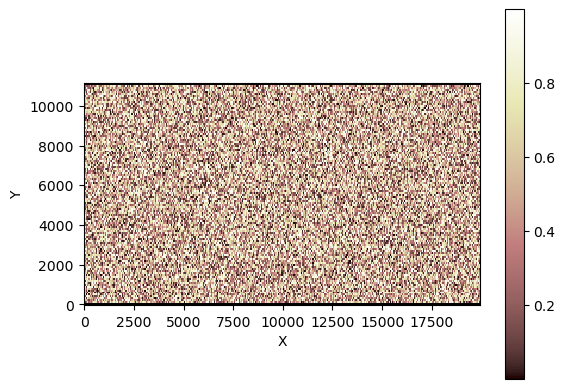

In [1]:
import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator,NormalFault
from landlab.components import FlowAccumulator, ChannelProfiler, ChiFinder, SteepnessFinder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio
from rasterio.transform import from_origin
from time import time
from FieldWork_class import FieldWork
import os

#Import you field work data
data = pd.read_csv('field_work_teton_park.csv')
data

#Calculate parameters for your model
fw = FieldWork(data)
dip_mean = fw.calculate_dip_strike()

#Set the size of your area
x_size = 20000 # in meters
y_size  = 11250 # in meters
dx = 60 #cell resolution in x
dy = 100 #cell resolution in y

rows, cols = map(int, fw.calculate_grid_size(x_size, y_size, dx, dy))

#create basin_mg
basin_mg = RasterModelGrid((rows,cols),xy_spacing=(dx,dy)) #rows = y, cols = x
# Add elevation field
np.random.seed(35)
z = basin_mg.add_zeros('topographic__elevation', at='node')
z += np.random.rand(z.size)

# Set boundary conditions to match Teton

basin_mg.set_closed_boundaries_at_grid_edges(False,True,False,True) #top,left,bottom,right
imshow_grid(basin_mg, 'topographic__elevation')
# plt.show()

In [2]:
## Initialise the landscape and parameters

# Dictionary for parameter values
params  = {'stream_power': {'K_sp': 0.00006, 
                        'n_sp': 1, 
                        'm_sp': 0.3}, 
                        'diffuser': {'D_diff': 0.003}}

K_sp = params['stream_power']['K_sp']
m_sp = params['stream_power']['m_sp']
n_sp = params['stream_power']['n_sp']

# Total forward model runtime
n_steps = 100001
dt = 1000  # timestep in years

# Create uplift arry
U = np.ones(basin_mg.number_of_nodes)
uplift_rate = 0.000500 #in meters/years
U = U*uplift_rate
uplift_per_steps = dt * U

# Instantiate components with parameter values
fa = FlowAccumulator(basin_mg, flow_director='D8')
ld = LinearDiffuser(basin_mg, linear_diffusivity=params['diffuser']['D_diff'])
sp = StreamPowerEroder(basin_mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)

### Run the forward model to evolve a landscape
Now we are ready to run our forward model to evolve the synthetic landscape. Did the Teton fault occur on a 'flat' landscape? Probably not. A simple assumption is that faulting occurred on a pre-existing topography. Let's run our model for 10 Myr, until it reaches a 'topographic steady state'. This will be defined as when the change in mean elevation between each model timestep is less than a threshold value.

Each model timestep consists of four steps:
1. Implement uplift as a block on the landscape by adding elevations equal to the uplift rate * model timestep
2. Calculate drainage area by running the `FlowAccumulator` component
3. Erode the fluvial network by running the `StreamPowerEroder` component
4. Diffuse the landscape by running the `LinearDiffuser` component

We will loop through these four steps until our model runtime reaches 10 Myr.


In [3]:
def save_to_tif(grid, timestep):
    transform = from_origin(0, 0, dx, dy)
    elevation = grid.at_node['topographic__elevation'].reshape((rows, cols))
    with rasterio.open(
        f'elevation_timestep_{timestep}.tif',
        'w',
        driver='GTiff',
        height=elevation.shape[0],
        width=elevation.shape[1],
        count=1,
        dtype=elevation.dtype,
        crs='+proj=latlong',
        transform=transform,
    ) as dst:
        dst.write(elevation, 1)

def save_to_npy(grid, timestep):
    filename="elevation_timestep_"+str(timestep)+".npy"
    elevation = grid.at_node['topographic__elevation']
    np.save(filename, elevation)

In [ ]:
# Run the forward model to evolve a landscape
start = time()       
for i in range(n_steps):

     basin_mg.at_node['topographic__elevation'][basin_mg.core_nodes] += uplift_per_steps[basin_mg.core_nodes]
     fa.run_one_step()
     sp.run_one_step(dt=dt)
     ld.run_one_step(dt)

    # Print some outputs as the model runs
     if i%100 == 0:
         print(f"currect time is {(time() - start)/60:.2f} mins")
         imshow_grid(basin_mg, 'topographic__elevation')
         plt.show()
         print(i)
         save_to_tif(basin_mg, i)
         save_to_npy(basin_mg, i)
end = time()
print(f"Total computation time is {(end - start)/60:.2f} mins")

The model takes a bit of time to run. You can run this yourself, but in the meantime we will load in some saved results below.

What does this final landscape look like? Let's extract some topographic metrics to examine the landscape.

In [4]:
def plot_topographic_metrics(grid_, channel_profiler_, time_, save=False):
    """ Produce a four-panel plot of topographic metrics for a landscape.
    (a) Elevation map
    (b) Longitudinal profiles
    (c) Chi map
    (d) Chi profiles
    (e) Channel steepness map

    Parameters:
    -----------------
    grid_: Landlab RasterModelGrid
    channel_profiler_: Landlab ChannelProfiler object
    time_: Age of the landscape in kyr
    save: Save the resulting figure as png in the current directory. Default is false

    Returns figure.
    """
    
    # Instantiate figure
    fig = plt.figure(figsize=(10, 10))
    shp = (3, 2)
    ax0 = plt.subplot2grid(shp, (0, 0), rowspan=1, colspan=1, aspect='auto')  # Topo with rivers
    ax1 = plt.subplot2grid(shp, (0, 1), rowspan=1, colspan=1, aspect='auto')  # Long profiles
    ax2 = plt.subplot2grid(shp, (1, 0), rowspan=1, colspan=1, aspect='auto')  # Chi map
    ax3 = plt.subplot2grid(shp, (1, 1), rowspan=1, colspan=1, aspect='auto')  # chi values
    ax4 = plt.subplot2grid(shp, (2, 0), rowspan=1, colspan=1, aspect='auto')  # steepness map

    # Colorbar axes
    divider0 = make_axes_locatable(ax0)
    cbar_ax0 = divider0.append_axes("left", size="5%", pad=0.5)
    divider2 = make_axes_locatable(ax2)
    cbar_ax2 = divider2.append_axes("left", size="5%", pad=0.5)
    divider4 = make_axes_locatable(ax4)
    cbar_ax4 = divider4.append_axes("left", size="5%", pad=0.5)
    cbar_ax4.yaxis.set_ticks_position('left')
    
    # # Axes ticks and labels
    # xticks = np.array([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
    # xlabels = [0, 2, 4, 6, 8, 10, 12, 14]
    # yticks = np.array([0, 2000, 4000, 6000, 8000, 10000])
    # ylabels = [0, 2, 4, 6, 8, 10]

    # Extract max dimensions from grid
    max_x = grid_.x_of_node[-1]
    max_y = grid_.y_of_node[-1]
    
    # Plot topography with long profiles
    im0 = ax0.imshow(grid_.at_node['topographic__elevation'].reshape(grid_.shape), aspect='auto', origin='lower',
                     cmap='terrain', extent=[0, max_x, 0, max_y])
    ax0.set_xlabel('Distance [m]'), ax0.set_ylabel('Distance [m]')
    # ax0.set_xticks(xticks, xlabels)
    # ax0.set_yticks(yticks, ylabels)
    ax0.yaxis.set_label_position("right")
    ax0.yaxis.tick_right()
    # Line segments for Long Profiles
    endpoints_only = False
    segments = []
    for nodes in channel_profiler_.nodes:
        if endpoints_only:
            select_nodes = [nodes[0], nodes[-1]]
            segments.append(list(zip(
                        grid_.x_of_node[select_nodes],
                        grid_.y_of_node[select_nodes])))
        else:
            segments.append(list(zip(grid_.x_of_node[nodes], grid_.y_of_node[nodes])))
    
    line_segments = LineCollection(segments)
    colors = channel_profiler_.colors
    line_segments.set_color(colors)
    ax0.add_collection(line_segments)
    # Add text
    ax0.text(0.5, 0.98, f'$\\tau$ = {time_} kyr', transform=ax0.transAxes, ha='center', va='top', bbox=dict(fc='w'))
    ax0.text(0.015, 0.98, 'a', transform=ax0.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    cb0 = plt.colorbar(im0, cax=cbar_ax0, orientation='vertical', label='Elevation [m]')
    cb0.ax.yaxis.set_ticks_position('left'), cb0.ax.yaxis.set_label_position('left')
    
    # Plot long profiles
    plt.subplot(322)
    channel_profiler_.plot_profiles(xlabel='Upstream Distance [m]',
                      ylabel='Elevation [m]', title='Longitudinal Profiles')
    ax1.text(0.015, 0.98, 'b', transform=ax1.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    # Plot chi map
    im2 = ax2.imshow(grid_.at_node['channel__chi_index'].reshape(grid_.shape), aspect='auto', origin='lower',
                     cmap='jet', extent=[0, max_x, 0, max_y])
    ax2.set_xlabel('Distance [m]'), ax2.set_ylabel('Distance [m]')
    # ax2.set_xticks(xticks, xlabels)
    # ax2.set_yticks(yticks, ylabels)
    ax2.text(0.015, 0.98, 'c', transform=ax2.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    cb2 = plt.colorbar(im2, cax=cbar_ax2, label='Chi index [m]', orientation='vertical')
    cb2.ax.yaxis.set_ticks_position('left'), cb2.ax.yaxis.set_label_position('left')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
    # Plot chi profiles
    plt.subplot(324)
    for i, outlet_id in enumerate(channel_profiler_.data_structure):
        for j, segment_id in enumerate(channel_profiler_.data_structure[outlet_id]):
            if j == 0:
                label = f"channel {i + 1}"
            else:
                label = "_nolegend_"
            segment = channel_profiler_.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            color = segment["color"]
            plt.plot(
                grid_.at_node["channel__chi_index"][profile_ids],
                grid_.at_node["topographic__elevation"][profile_ids],
                color=color,
                label=label,
            )
    
    ax3.set_xlabel("Chi Index [m]")
    ax3.set_ylabel("Elevation [m]")
    ax3.text(0.015, 0.98, 'd', transform=ax3.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()

    # Plot channel steepness
    im4 = ax4.imshow(grid_.at_node['channel__steepness_index'].reshape(grid_.shape), origin='lower', aspect='auto',
                    cmap='jet', extent=[0, max_x, 0, max_y])
    ax4.set_xlabel('Distance [m]'), ax4.set_ylabel('Distance [m]')
    # ax4.set_xticks(xticks, xlabels)
    # ax4.set_yticks(yticks, ylabels)
    ax4.text(0.015, 0.98, 'e', transform=ax4.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    cb4 = plt.colorbar(im4, cax=cbar_ax4, label='Steepness index', orientation='vertical')
    cb4.ax.yaxis.set_ticks_position('left'), cb4.ax.yaxis.set_label_position('left')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()
    
    plt.tight_layout()

    if save:
        plt.savefig('synthetic_results_' + time_ +'.png', dpi=300)

    return None

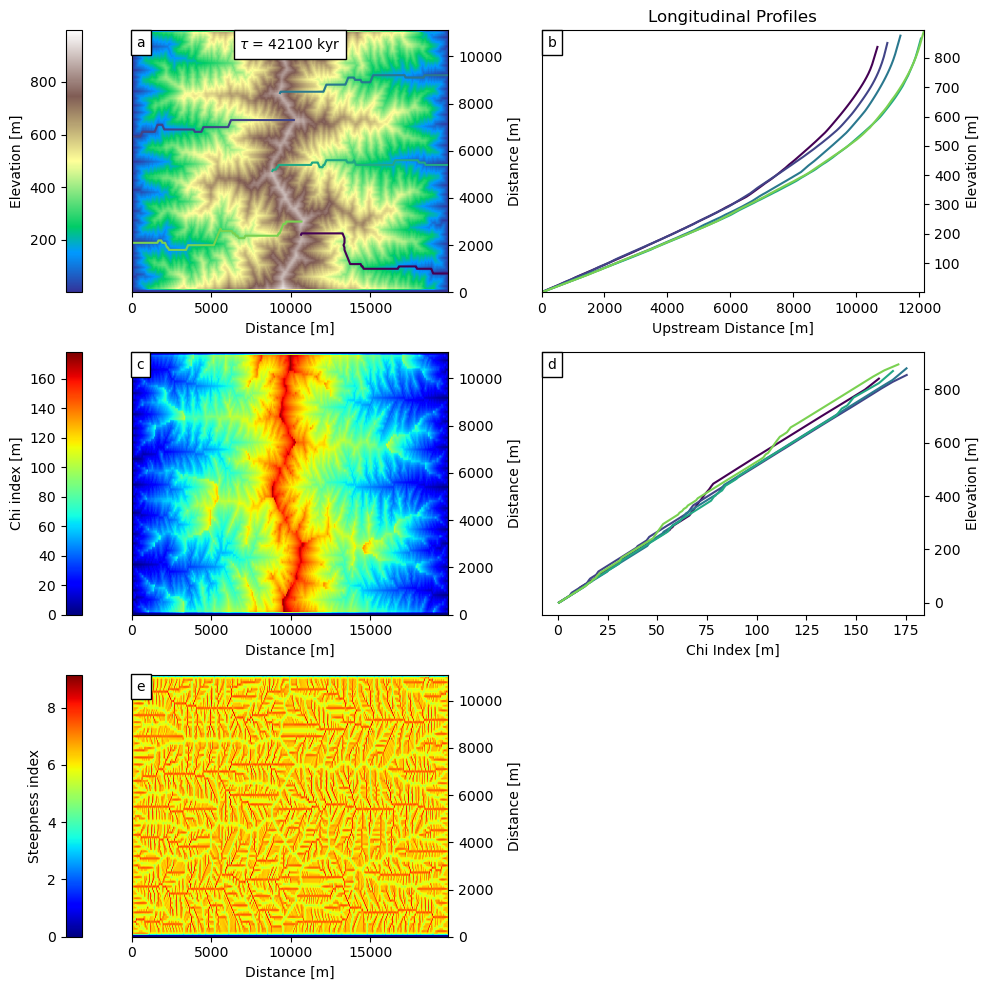

In [19]:
# Reload saved results and assign to a new grid object
basin_fault_mg = RasterModelGrid((rows,cols),xy_spacing=(dx,dy))
basin_fault_mg.at_node['topographic__elevation'] = np.load("steady_state_scenario.npy")

# Set elevation variable
z_f = basin_fault_mg.at_node['topographic__elevation']

# Reassign boundary conditions
basin_fault_mg.set_closed_boundaries_at_grid_edges(False,True,False,True)

# Run flow accumulation to calculate drainage area
fa = FlowAccumulator(basin_fault_mg, flow_director='D8')
fa.run_one_step()

# Extract rivers
cp = ChannelProfiler(basin_fault_mg, number_of_watersheds=5)
cp.run_one_step()

# Extract chi
cf = ChiFinder(basin_fault_mg, min_drainage_area=1000.0, reference_concavity=0.3, clobber=True)
cf.calculate_chi()

# Calculate channel steepness
sf = SteepnessFinder(basin_fault_mg, reference_concavity=0.3, min_drainage_area=1000.0)
sf.calculate_steepnesses()

# Plot results
age = 42100  # kyr
plot_topographic_metrics(basin_fault_mg, cp, age, save=False)

### Landscape Analysis
Looking at each figure in turn:
(a) What is the general structure of the landscape? Is it clear how the boundary conditions have influenced the development of drainage? What is the maximum elevation?<br>
(b) What is the general shape of the longitudinal profiles? Are they concave and smooth, or do they contain changes in gradient representing knickzones?<br>
(c) What patterns does the chi map show? Does chi increase towards the centre of the landscape, or are there changes in chi between the E-W boundaries and the centre?<br>
(d) Are the chi profiles broadly linear and collapse on to each other? What does this tell us?<br>
(e) What patterns does the channel steepness map show?<br>


This landscape can now serve as an initial condition for normal faulting. Let's instantiate a new grid and reinitialise the model components. This time, we require the `NormalFault` component. We will specify a fault trace and fault dip based off the Teton Fault, and a fault uplift rate. Our forward model now will include this normal fault component too. What happens to the landscape when we include normal faulting?


In [20]:
## Setting parameters for normal fault event
uplift_rate = 0.0002 #set fault uplift rate (in mm/yr)
dip_angle = dip_mean # this come from the measurements we took on the field trip
bottom_xy_coord = (8000,0)  # Sets fault trace at lower boundary, based on the location of field outcrops
top_xy_coord = fw.calculate_topxy(basin_mg,bottom_xy_coord[0],bottom_xy_coord[1]) # this will be calculated based on the strike measurements 

## running fault code

# Load fault parameters
folder_name = f'model_fault_scenario_0'
os.makedirs(folder_name, exist_ok=True)

image_folder = 'images'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

params_fault = {
            "faulted_surface": "topographic__elevation",
            "fault_dip_angle": dip_angle,
            "fault_throw_rate_through_time": {
                "time": [10000],
                "rate": [uplift_rate],
            },#
            "fault_trace": {"y1": bottom_xy_coord[1], "x1": bottom_xy_coord[0], "y2": top_xy_coord[1], "x2": top_xy_coord[0]},
            "include_boundaries":False,
        }

# Reinstantiate model components
fa = FlowAccumulator(basin_fault_mg, flow_director='D8')
ld = LinearDiffuser(basin_fault_mg, linear_diffusivity=params['diffuser']['D_diff'])
sp = StreamPowerEroder(basin_fault_mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)
nf= NormalFault(basin_fault_mg,**params_fault)  # Include this normal fault component

Now we can run the landscape evolution model including the Normal Fault

In [ ]:
# Run forward model
for i in range(n_steps):
    fa.run_one_step()
    sp.run_one_step(dt)
    ld.run_one_step(dt)
    nf.run_one_step(dt)

    # Print some information and calculate topographic metrics as the landscape evolves
    if i%100== 0:
        
        # Extract rivers
        cp = ChannelProfiler(basin_fault_mg, number_of_watersheds=5)
        cp.run_one_step()
        
        # Extract chi
        cf = ChiFinder(basin_fault_mg, min_drainage_area=10000.0, reference_concavity=0.45, clobber=True)
        cf.calculate_chi()
        
        # Calculate channel steepness
        sf = SteepnessFinder(basin_fault_mg, reference_concavity=0.45, min_drainage_area=10000.0)
        sf.calculate_steepnesses()
        
        plot_topographic_metrics(basin_fault_mg,cp,(i*dt))
       

        image_filename = os.path.join(image_folder, f"frame_{i}.png")
        plt.savefig(image_filename)
        plt.show()
        
        filename = os.path.join(folder_name, f"model_teton_fault_in_year_{i}.txt")
        np.savetxt(filename,basin_fault_mg.at_node['topographic__elevation'])


In [23]:
from PIL import Image

# Get all the image file names in the image folder
image_folder_2 = 'images/new_filenames/keep'
image_files = sorted([os.path.join(image_folder_2, f) for f in os.listdir(image_folder_2) if f.endswith('.png')])

# List to hold the image objects
images = []

for file in image_files:
    img = Image.open(file)
    images.append(img)

# Save the images as a GIF
if images:
    output_gif = 'output_20Myr.gif'
    images[0].save(output_gif, save_all=True, append_images=images[1:], duration=500, loop=0)
else:
    print("No images found to create GIF")


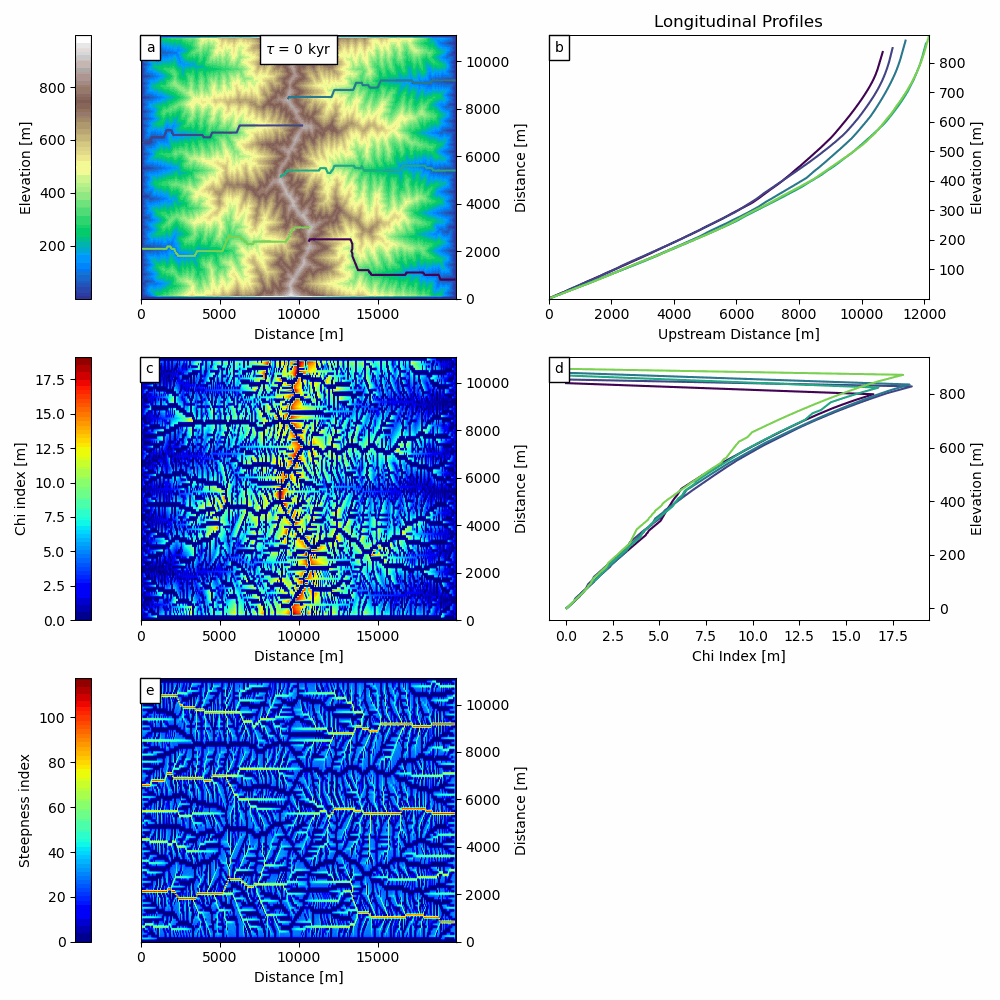

Let's look at our topographic metrics again:
* Looking at **(a)**: How does the drainage divide compare to the steady-state landscape? Is it in the same position, or has it migrated East or West? How does the maximum elevation compare to the steady-state landscape?
* Looking at **(b)**: How do the longitudinal profiles compare to the steady state landscape? Do you observe any knickzones which weren't present before?
* Looking at **(c) and (d)**: How does the chi map compare to the steady state landscape? What patterns can you observe?
* Looking at **(e)**: How does channel steepness index compare to the steady state landscape?

## Conclusions
We have seen how we can use Landlab to analyse an observed landscape from a DEM, and generate a synthetic landscape to try and approximate this landscape. We have also seen how a 'steady-state' synthetic landscape compares to a faulted synthetic landscape.

* How successful do you think this approach is?
* What are the positives and drawbacks? Do you think the synthetic model requires more complexity?
* If so, which other landscape evolution processes would you incorporate?
* Are there any assumptions which you think are inappropriate?
* Are there any other topographic metrics which you think would be useful to compare?